FSSC Science Tools
=========================
Fermi LAT Likelihood Analysis: Livetime, Exposure and pyLike
-------------------------
*Jeremy S. Perkins, FSSC*

**Goal:** *Complete a simple likelihood analysis*

The Quick Summary of What We're Going to Do
-------------------------------------------

* We observed a photon from a location, at a specific time, with a specific energy
* We assume a model:
$$S(E,\hat{p},t) = \sum_i s_i(E,t)\delta(\hat{p}-\hat{p}_i)
                        + S_G(E,\hat{p}) + S_{eg}(E,\hat{p})
                        + \sum_l S_l(E,\hat{p},t)$$
* The model is defined as 
    * a summation over point sources,
    * the galactic and extra-galactic diffuse
    * and a summataion over anything else.
* We calculate the probability of that photon being detected assuming our model:

$$M(E',\hat{p}',t) = \int_{SR} dEd\hat{p}R(E',\hat{p}',t;E,\hat{p})S(E,\hat{p},t)$$

* Then we calculate the total number of predicted counts assuming our model:

$$N_{pred} = \int_{SR} dEd\hat{p}S(E,\hat{p})\epsilon(E,\hat{p})$$

* epsilon is a model-independent quantitity called the exposure map (or cube)
    * it's not the exposure in a traditional sense, but useful nomenclature.
* **epsilon can be precomputed so it saves time in the Likihood optimization**

$$\epsilon(E,\hat{p}) \equiv \int_{ROI} dE'd\hat{p}'dt R(E',\hat{p}',t; E,\hat{p})$$

* Now we adjust our model until the following is maximised:

$$\log L = \sum_j \log M(E'_j,\hat{p}'_j,t_j) - N_{pred}$$

* And we calculate the TS

$$TS = -2 \log \frac{L_{max,0}}{L_{max,1}}$$

Calculating Livetime and Exposure
---------------------------------
* Calculating the exposure is a two-step process
    * **Livetime:** formally the time when the detector is available to collect data
        * For analysis, we additionally require good data quality and select to remove high background
        * The LAT has a large FoV with varying response: need to know when and where
    * **Exposure:** for practical purposes, the number that converts counts to photon flux
        * Apply expected photon detection efficiency and angular resolution
            * Depends on the event selection
            * Depends on the direction of the photon relative to the instrument boresight and energy

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from matplotlib import transforms
from IPython.display import Image
import numpy as np

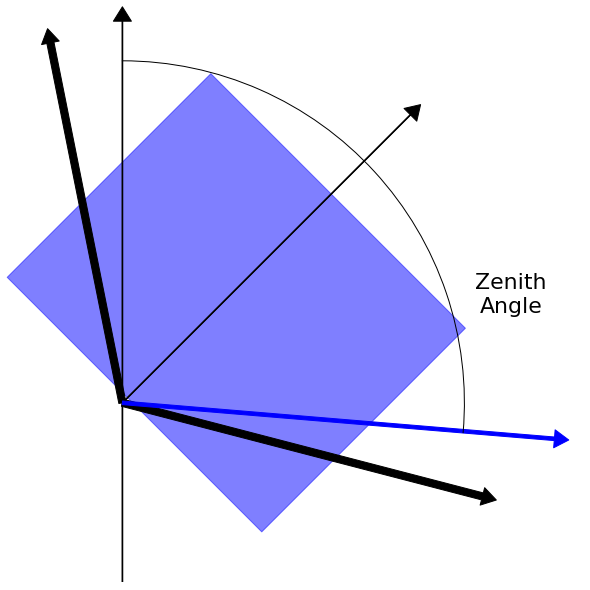

In [3]:
from matplotlib.patches import Circle, Rectangle, Polygon, Arrow, FancyArrow, Arc
box_bg = '#CCCCCC'
fig = plt.figure(figsize=(8, 8), facecolor='w')
ax = plt.axes((0,0,1,1),xticks=[], yticks=[], frameon=False)
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)

          
r1 = Rectangle((-3,3), 5, 4, color="blue", alpha=0.50)
t2 = transforms.Affine2D().rotate_deg(-45) + ax.transData
r1.set_transform(t2)

a1 = FancyArrow(1.6, 2.5, 4.0, 4.0, width=0.01, head_width=0.25, head_length=0.2, color="black")
a2 = FancyArrow(1.6, 0.0, 0.0, 7.8, width=0.01, head_width=0.25, head_length=0.2, color="black")

a3 = FancyArrow(1.6, 2.5, 5.0, -1.3, width=0.1, head_width=0.25, head_length=0.2, color="black")
a4 = FancyArrow(1.6, 2.5, -1.0, 5.0, width=0.1, head_width=0.25, head_length=0.2, color="black")
a5 = FancyArrow(1.6, 2.5, 6.0, -0.5, width=0.05, head_width=0.25, head_length=0.2, color="blue")

a6 = Arc((1.6,2.5),9.5,9.5,25,330,65)

ax.add_patch(r1)
ax.add_patch(a1)
ax.add_patch(a2)
ax.add_patch(a3)
ax.add_patch(a4)
ax.add_patch(a5)
ax.add_patch(a6)

plt.text(7, 4.0, "Zenith\nAngle",
            ha='center', va='center', fontsize=22)

plt.grid(True)
plt.show()

###Livetime
* Sum up time spent in the field of view for each position in the celestial sky
    * Inputs are the photon and spacecraft files
    * Options are pixel size and step size for the instrument angles
    * Output is a livetime ‘cube’
    * Respects time-based selection cuts made with gtmktime (GTIs)
* **Livetime and Maximum Zenith Angle**
    * gtltcube knowns about the field of view and the spacecraft pointing (via the spacecraft file) and can make exposure corrections related to this corrodinate systems.
    * If you are doing an all-sky analysis or non-stantdard zenith cut, gtltcube can make a correction for the exposure loss from a zenith angle cut in gtselect.
        * **note:** this assumes perfect reconstruction
    * **If you're doing a basic source analysis and using the standard ROI cut you don't need to do this.**
    
* Example: if you use *zmax = 100* in *gtselect* and set *ROIcut = no* in *gtmktime* then you **must** use *zmax=100* in *gtltcube*.

Let's do this now (doing it the python way, you can just run *gtltcube* from the command line if you wish)...

In [4]:
from gt_apps import expCube

In [5]:
expCube.pars()

' evfile="" evtable="EVENTS" scfile= sctable="SC_DATA" outfile=expCube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"'

In [6]:
expCube['evfile'] = 'data/3C279_filtered_gti.fits'
expCube['scfile'] = 'data/L1405221252264C652E7F67_SC00.fits'
expCube['outfile'] = 'data/3C279_ltcube.fits'
expCube['dcostheta'] = 0.025
expCube['binsz'] = 1.0

In [7]:
expCube.run()

time -p /home/fermiuser/AstroSoft/ScienceTools/x86_64-unknown-linux-gnu-libc2.12/bin/gtltcube evfile="data/3C279_filtered_gti.fits" evtable="EVENTS" scfile=data/L1405221252264C652E7F67_SC00.fits sctable="SC_DATA" outfile=data/3C279_ltcube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file data/L1405221252264C652E7F67_SC00.fits
.....................!
real 912.56
user 895.22
sys 5.48


This takes a while to run...

In [8]:
912.56 /60

15.209333333333332

Fifteen minutes in fact... As usual, let's see what we have here.

In [9]:
import pyfits

In [10]:
ltcube_hdu = pyfits.open('data/3C279_ltcube.fits')

In [11]:
print ltcube_hdu.info()

Filename: data/3C279_ltcube.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      27   ()           uint8   
1    EXPOSURE    BinTableHDU     59   49152R x 3C   [40E, E, E]   
2    WEIGHTED_EXPOSURE  BinTableHDU     59   49152R x 3C   [40E, E, E]   
3    CTHETABOUNDS  BinTableHDU     33   40R x 2C     [E, E]   
4    GTI         BinTableHDU     46   3703R x 2C   [D, D]   
None


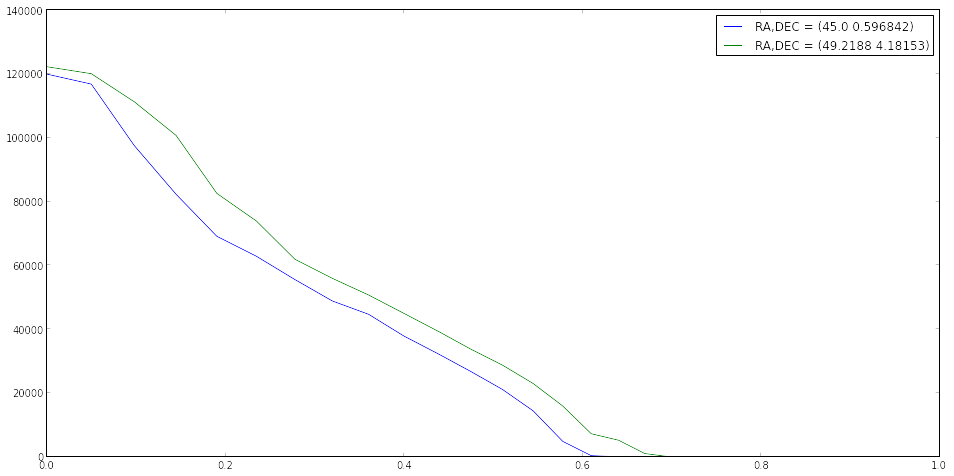

In [12]:
plt.figure(figsize=(16,8))
label_txt = "RA,DEC = ({} {})".format(ltcube_hdu[1].data.field('ra')[0],ltcube_hdu[1].data.field('dec')[0])
plt.plot(ltcube_hdu[3].data.field('CTHETA_MIN'),ltcube_hdu[1].data.field('cosbins')[0],label=label_txt)
label_txt = "RA,DEC = ({} {})".format(ltcube_hdu[1].data.field('ra')[20],ltcube_hdu[1].data.field('dec')[20])
plt.plot(ltcube_hdu[3].data.field('CTHETA_MIN'),ltcube_hdu[1].data.field('cosbins')[20],label=label_txt)
plt.legend()
plt.show()

### Now lets calculate the exposure map

In [13]:
from gt_apps import expMap

In [14]:
expMap.pars()

' evfile= evtable="EVENTS" scfile= sctable="SC_DATA" expcube= outfile= irfs="CALDB" srcrad=30.0 nlong=120 nlat=120 nenergies=20 submap=no nlongmin=0 nlongmax=0 nlatmin=0 nlatmax=0 chatter=2 clobber=yes debug=no gui=no mode="ql"'

In [15]:
expMap['evfile'] = 'data/3C279_filtered_gti.fits'
expMap['scfile'] = 'data/L1405221252264C652E7F67_SC00.fits'
expMap['expcube'] = 'data/3C279_ltcube.fits'
expMap['outfile'] = 'data/3C279_expmap.fits'
expMap['irfs'] = 'P7REP_SOURCE_V15'
expMap['srcrad'] = 30
expMap['nlong'] = 120
expMap['nlat'] = 120
expMap['nenergies'] = 20

In [16]:
expMap.run()

time -p /home/fermiuser/AstroSoft/ScienceTools/x86_64-unknown-linux-gnu-libc2.12/bin/gtexpmap evfile=data/3C279_filtered_gti.fits evtable="EVENTS" scfile=data/L1405221252264C652E7F67_SC00.fits sctable="SC_DATA" expcube=data/3C279_ltcube.fits outfile=data/3C279_expmap.fits irfs="P7REP_SOURCE_V15" srcrad=30.0 nlong=120 nlat=120 nenergies=20 submap=no nlongmin=0 nlongmax=0 nlatmin=0 nlatmax=0 chatter=2 clobber=yes debug=no gui=no mode="ql"
The exposure maps generated by this tool are meant
to be used for *unbinned* likelihood analysis only.
Do not use them for binned analyses.
Computing the ExposureMap using data/3C279_ltcube.fits
....................!
real 322.95
user 313.80
sys 4.90


What do we have here..

In [17]:
expmap_hdu = pyfits.open('data/3C279_expmap.fits')

In [18]:
expmap_hdu.info()

Filename: data/3C279_expmap.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      51   (120, 120, 20)   float32   
1    ENERGIES    BinTableHDU     13   20R x 1C     [1D]   
2    GTI         BinTableHDU     18   3703R x 2C   [D, D]   


In [19]:
import time
from IPython.display import display,clear_output

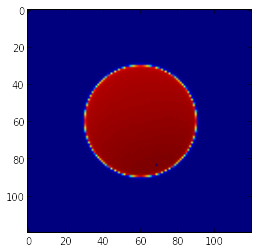

In [20]:
f, ax = plt.subplots()
for expmap in expmap_hdu[0].data:
    time.sleep(0.2)
    plt.imshow(expmap)
    clear_output(wait=True)
    display(f)
    ax.cla()
    
plt.close()

### Why did we pick the binning we did?

* Response functions are minimally parameterized in the inclination angle (theta) and energy
    * Bin or step sizes used in exposure calculations should consider how quickly the efficiency changes in space or energy
        * At least 10 bins per decade in energy to avoid errors in estimation where the effective area changes rapidly
        * No single, strict recommendation on spatial binning
            * 1 deg default sufficient for making maps
            * The Binned likelihood is matched to data binning
    * gtexposure invokes a spectral assumption - this has a noticeable impact  
        * Remember that both the efficiency and angular reconstruction depend on energy

The Optimization
====================

We now have everyhitng we need to perform the maximum likelihood optimization.  We have the photons, we have the exposure but we don't have a model.  We'll talk about how to build this model in a bit but for now, I'm giving you a sample model definition for the purposes of this analysis.  Here's what the file looks like:

    <?xml version="1.0" ?>
    <source_library title="source library" xmlns="http://fermi.gsfc.nasa.gov/source_library">

    <source name="iso_source_v05.txt" type="DiffuseSource">
        <spectrum file="data/iso_source_v05.txt" type="FileFunction">
            <parameter free="1" max="1000" min="1e-05" name="Normalization" scale="1" value="1" />
        </spectrum>
        <spatialModel type="ConstantValue">
            <parameter free="0" max="10.0" min="0.0" name="Value" scale="1.0" value="1.0"/>
        </spatialModel>
    </source>

    <source name="gll_iem_v05_rev1" type="DiffuseSource">
        <spectrum type="ConstantValue">
            <parameter free="1" max="10.0" min="0.0" name="Value" scale="1.0" value= "1.0"/>
        </spectrum>
        <spatialModel file="data/gll_iem_v05_rev1.fit" type="MapCubeFunction">
            <parameter free="0" max="1000.0" min="0.001" name="Normalization" scale= "1.0" value="1.0"/>
        </spatialModel>
    </source>

    <source name="3C 273" type="PointSource">
        <spectrum type="PowerLaw">
            <parameter free="1" max="1000.0" min="0.001" name="Prefactor" scale="1e-09" value="10"/>
            <parameter free="1" max="-1.0" min="-5.0" name="Index" scale="1.0" value="-2.1"/>
            <parameter free="0" max="2000.0" min="30.0" name="Scale" scale="1.0" value="100.0"/>
        </spectrum>
        <spatialModel type="SkyDirFunction">
            <parameter free="0" max="360" min="-360" name="RA" scale="1.0" value="187.25"/>
            <parameter free="0" max="90" min="-90" name="DEC" scale="1.0" value="2.17"/>
        </spatialModel>
    </source>

    <source name="3C 279" type="PointSource">
        <spectrum type="PowerLaw">
            <parameter free="1" max="1000.0" min="0.001" name="Prefactor" scale="1e-09" value="10"/>
            <parameter free="1" max="-1.0" min="-5.0" name="Index" scale="1.0" value="-2"/>
            <parameter free="0" max="2000.0" min="30.0" name="Scale" scale="1.0" value="100.0"/>
        </spectrum>
        <spatialModel type="SkyDirFunction">
            <parameter free="0" max="360" min="-360" name="RA" scale="1.0" value="193.98"/>
            <parameter free="0" max="90" min="-90" name="DEC" scale="1.0" value="-5.82"/>
        </spatialModel>
    </source>

    </source_library>

The model file is stored in a format called eXtensible Markup Language (XML) which is just a set of rules to encode information in a text file.  The model file is our description of what we think the region should look like.  You'll hear more about how to create these files later.

You can download this file: [3C_279_input_model.xml](https://raw.github.com/kialio/fermi-summer-school/master/3C279_input_model.xml)

Notice that the model file makes refernce to two files, [iso_source_v05.txt](http://fermi.gsfc.nasa.gov/ssc/data/analysis/software/aux/iso_source_v05.txt) and [gll_iem_v05_rev1.fits](http://fermi.gsfc.nasa.gov/ssc/data/analysis/software/aux/gll_iem_v05_rev1.fits).  These two files describe the extragalactic and galactic diffuse emission respectively.  They are provided as part of the Science Tools distribution but we need to link them into our working directory so that the likelihood code can find them.

In [21]:
from os import environ

In [22]:
environ['FERMI_DIR']

'/home/fermiuser/AstroSoft/ScienceTools/x86_64-unknown-linux-gnu-libc2.12'

In [23]:
ls /home/fermiuser/AstroSoft/ScienceTools/x86_64-unknown-linux-gnu-libc2.12/refdata/fermi/galdiffuse

EGRET_diffuse_cel.fits@        iso_source_back_v05_rev1.txt@
EGRET_diffuse_gal.fits@        iso_source_front_v05_rev1.txt@
gll_iem_v02.fit@               iso_source_v05_rev1.txt@
gll_iem_v05_rev1.fit@          iso_source_v05.txt@
GP_gamma.fits@                 isotrop_4years_P7_v9_repro_clean_front_v1.txt@
GP_gamma_v0r0p1.fits@          isotrop_4years_P7_v9_repro_clean_v1.txt@
iso_clean_back_v05_rev1.txt@   isotrop_4years_P7_v9_repro_source_v1.txt@
iso_clean_front_v05_rev1.txt@  isotropic_iem_back_v02_P6_V11_DIFFUSE.txt@
iso_clean_v05_rev1.txt@        isotropic_iem_front_v02_P6_V11_DIFFUSE.txt@
iso_clean_v05.txt@             isotropic_iem_v02_P6_V11_DIFFUSE.txt@
iso_p7v6clean.txt@             isotropic_iem_v02.txt@
iso_p7v6source.txt@            template_4years_P7_v9_repro_v1.fits@


_Note that you should probably use symbolic links instead of just copying big files around that you use over and over again_

In [24]:
!cp /home/fermiuser/AstroSoft/ScienceTools/x86_64-unknown-linux-gnu-libc2.12/refdata/fermi/galdiffuse/gll_iem_v05_rev1.fit data/
!cp /home/fermiuser/AstroSoft/ScienceTools/x86_64-unknown-linux-gnu-libc2.12/refdata/fermi/galdiffuse/iso_source_v05.txt data/

In [25]:
ls data

3C279_expmap.fits         iso_source_v05.txt
3C279_filtered_gti.fits@  L1405221252264C652E7F67_PH00.fits@
3C279_ltcube.fits         L1405221252264C652E7F67_PH01.fits@
gll_iem_v05_rev1.fit      L1405221252264C652E7F67_SC00.fits@


Notice that these are suspiciously named like they might depend on the event class you're using.  You would be right to assume so.  Let's take a look at these.  The isotropic diffuse model is just a text file:

In [26]:
import numpy as np

In [27]:
isotropic = np.genfromtxt("data/iso_source_v05.txt")

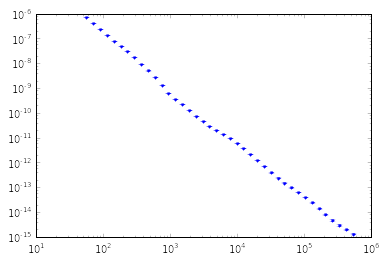

In [28]:
plt.yscale('log')
plt.xscale('log')
plt.errorbar(isotropic[:,0],isotropic[:,1],yerr=isotropic[:,2],fmt='.')
plt.show()

The isotropic model is spatially isotropic but is energy dependent.  Open up the galactic diffuse:

In [29]:
gal_diff = pyfits.open("data/gll_iem_v05_rev1.fit")

In [30]:
gal_diff.info()

Filename: data/gll_iem_v05_rev1.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      35   (2880, 1441, 30)   float32   
1    ENERGIES    BinTableHDU     11   30R x 1C     [D]   


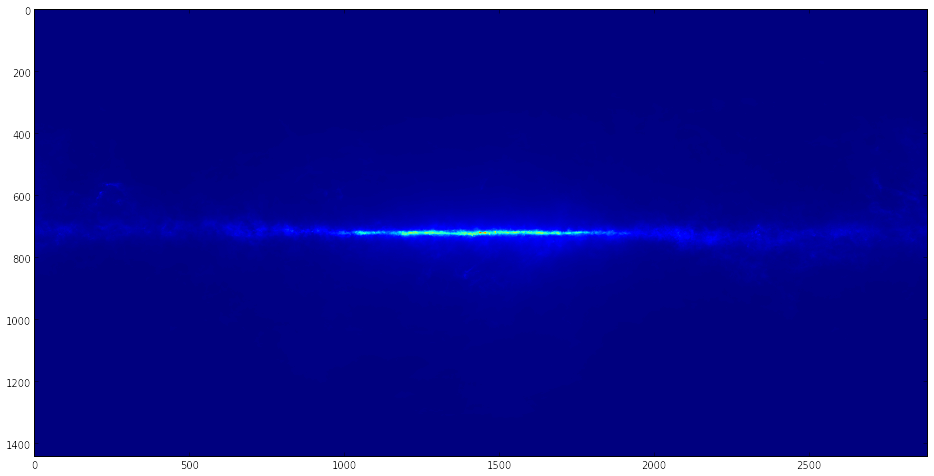

In [31]:
plt.figure(figsize=(16,16))
plt.imshow(gal_diff[0].data[0])
plt.show()

The model for the Galactic diffuse emission was developed using spectral line surveys of HI and CO (as a tracer of H2) to derive the distribution of interstellar gas in Galactocentric rings. Infrared tracers of dust column density were used to correct column densities in directions where the optical depth of HI was either over or under-estimated. The model of the diffuse gamma-ray emission was then constructed by fitting the gamma-ray emissivities of the rings in several energy bands to the LAT observations. The fitting also required a model of the inverse Compton emission calculated using GALPROP and a model for the isotropic diffuse emission. [A complete description of the Pass 7 Galactic diffuse model is available](http://fermi.gsfc.nasa.gov/ssc/data/access/lat/Model_details/Pass7_galactic.html).

I think we're ready to go now.  We're going to do this the python way (you could use *gtlike* if you wish).

In [32]:
from UnbinnedAnalysis import *

First, create an obsevation object which describes your observation.

In [33]:
obs = UnbinnedObs(eventFile='data/3C279_filtered_gti.fits', 
                  scFile='data/L1405221252264C652E7F67_SC00.fits', 
                  expMap='data/3C279_expmap.fits',
                  expCube='data/3C279_ltcube.fits',
                  irfs='P7REP_SOURCE_V15')

Now, create an analysis object.

In [34]:
analysis = UnbinnedAnalysis(obs,srcModel='3C279_input_model.xml', optimizer='NEWMINUIT')

Note that we selected an *optimizer*.  There are a couple of options (see the help file for gtlike) but most of the time you'll using one of the MINUIT optimizers (NEWMINUIT or MINUIT).  Now, we're ready to do the actual fit, but we can check out the objects we just created if we want.

In [35]:
analysis.tol

0.001

This is the tolerance for the fit we're about to perform and this is the type of tolerance we're using (1 = ??, 0 = ??):

In [36]:
analysis.tolType

1

There are lots of other variables and functions associated with these but we'll leave that to the advanced likelihood lecture tomorrow.  For now, lets do the fit.

In [37]:
analysis.fit()

815515.8994541339

The number returned is the log(Likelihood) of the full fit.  You should also see a lot of information printed to the terminal.  You can even get this number later:

In [38]:
analysis.logLike.value()

-815515.8994541339

So, that's all and good, how do I get at the results of the fit?

Well, you can look at the model this way:

In [39]:
analysis.model

3C 273
   Spectrum: PowerLaw
0      Prefactor:  1.024e+01  3.441e-01  1.000e-03  1.000e+03 ( 1.000e-09)
1          Index: -2.646e+00  2.440e-02 -5.000e+00 -1.000e+00 ( 1.000e+00)
2          Scale:  1.000e+02  0.000e+00  3.000e+01  2.000e+03 ( 1.000e+00) fixed

3C 279
   Spectrum: PowerLaw
3      Prefactor:  8.329e+00  2.502e-01  1.000e-03  1.000e+03 ( 1.000e-09)
4          Index: -2.233e+00  1.639e-02 -5.000e+00 -1.000e+00 ( 1.000e+00)
5          Scale:  1.000e+02  0.000e+00  3.000e+01  2.000e+03 ( 1.000e+00) fixed

gll_iem_v05_rev1
   Spectrum: ConstantValue
6          Value:  1.265e+00  1.945e-02  0.000e+00  1.000e+01 ( 1.000e+00)

iso_source_v05
   Spectrum: FileFunction
7     Normalization:  1.220e+00  2.223e-02  1.000e-05  1.000e+03 ( 1.000e+00)

You can also get at the test statistic of a specific source

In [40]:
analysis.Ts('3C 279')

10538.790799139999

and the number of predicted counts

In [41]:
analysis.NpredValue('3C 279')

5852.665965020014

You can bring up a counts spectrum of all of the sources (if you installed the root version of the tools):

In [42]:
analysis.plot()

Or, if you're feeling adventurous, plot it in python...

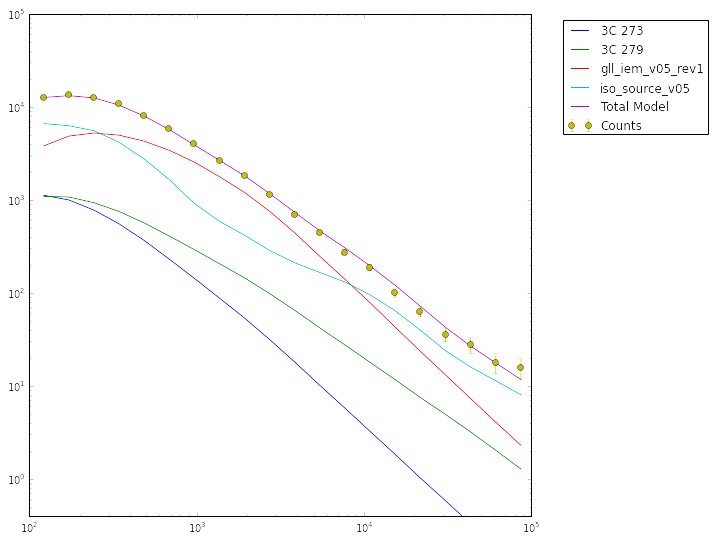

In [43]:
E = (analysis.energies[:-1] + analysis.energies[1:])/2.
#The 'energies' array are the endpoints so we take the midpoint of the bins.
plt.figure(figsize=(9,9))
plt.ylim((0.4,1e5))
plt.xlim((100,100000))
sum_model = np.zeros_like(analysis._srcCnts(analysis.sourceNames()[0]))
for sourceName in analysis.sourceNames():
    sum_model = sum_model + analysis._srcCnts(sourceName)
    plt.loglog(E,analysis._srcCnts(sourceName),label=sourceName)
plt.loglog(E,sum_model,label='Total Model')
plt.errorbar(E,analysis._Nobs(),yerr=np.sqrt(analysis._Nobs()), fmt='o',label='Counts')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

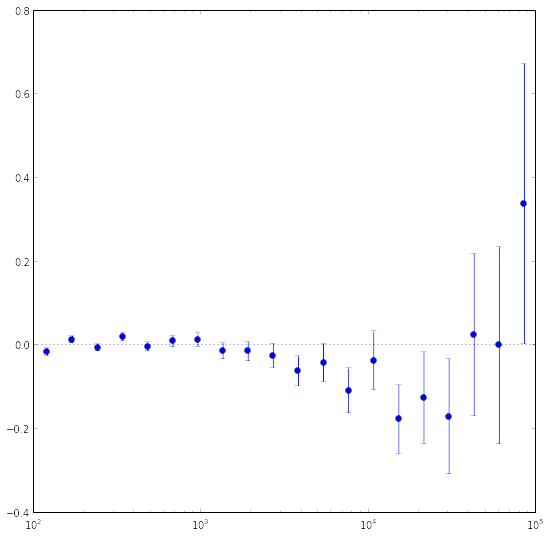

In [44]:
resid = (analysis._Nobs() - sum_model)/sum_model
resid_err = (np.sqrt(analysis._Nobs())/sum_model)
plt.figure(figsize=(9,9))
plt.xscale('log')
plt.errorbar(E,resid,yerr=resid_err,fmt='o')
plt.axhline(0.0,ls=':')
plt.show()

You can output a new XML model:

In [45]:
analysis.writeXml('3C279_output_model.xml')

You can get at the integral flux of a specific source:

In [46]:
print "3C 279 Integral Flux = {} +- {}".format(analysis.flux('3C 279'), analysis.fluxError('3C 279'))

RuntimeError: Covariance matrix has not been computed.

Oops.  Forgot to do that.  What's the covariance matrix?  It's basically the matrix of values that shows how each variable in your model depends on each other variable.  We can tell the fit to compute that.

In [47]:
analysis.fit(covar=True)

815515.8992138859

In [48]:
print "3C 279 Integral Flux = {} +- {}".format(analysis.flux('3C 279'), analysis.fluxError('3C 279'))

3C 279 Integral Flux = 6.76325666399e-07 +- 1.40249410592e-08


###What About?...

Tomorrow we'll go over the advanced likelihood and talk about things like

* Upper Limits
* Composite and Summed Likelihood
* Scripting
* Muliti-Core Processing
* User Contributed Tools
* Fit verification
* …and more